In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

import feather
import warnings
import time
import sys
import datetime
import re
import gc

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

from scipy.stats import mode
from scipy import stats
from sklearn import preprocessing


from IPython.core.display import display, HTML

In [ ]:
#2018/05/1 точка отчета

In [2]:
new_transactions = pd.read_csv('C:\\kdata\\new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('C:\\kdata\\historical_transactions.csv', parse_dates=['purchase_date'])

In [2]:
merchants = pd.read_csv('C:\\kdata\\merchants.csv')

In [ ]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018,5, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data('C:\\kdata\\train.csv')
test = read_data('C:\\kdata\\test.csv')

target = train['target']
del train['target']

In [3]:
global merch_id_replace_bins
global merch_category_id_bins
global merch_subsector_id_bins 
global merch_state_id_bins
global merch_city_id_bins


merch_id_replace_bins = pd.cut(merchants.merchant_group_id.value_counts(),bins=[0,1,6,20,60,100,250,1000,100000],include_lowest=True,labels=list(range(1,9))).to_dict()
merch_category_id_bins = pd.cut(merchants.merchant_category_id.value_counts(),bins=[0,10,50,200,500,1000,3000,5000,9000,12000,16000,20000,50000],include_lowest=True,labels=list(range(1,13))).to_dict()
for x in [27,37,192,220,311,603,687,817,882]:
    merch_category_id_bins[x] = 13
merch_subsector_id_bins = pd.cut(merchants.subsector_id.value_counts(),bins=[0,1,100,500,1000,5000,10000,18000,35000,80000],include_lowest=True,labels=range(1,10)).to_dict()
merch_state_id_bins = pd.cut(merchants.state_id.value_counts(),bins=[2000,4000,7000,10000,12000,16000,25000,50000,100000],include_lowest=True,labels=[2,3,4,1,5,6,7,8]).to_dict()
merch_city_id_bins = pd.cut(merchants.city_id.value_counts(),bins=[0,1,100,300,600,1000,2000,3000,6000,10000,30000,120000],include_lowest=True,labels=range(1,12)).to_dict()

In [3]:
global trans_city_id
global trans_state_id
global trans_subsector_id

trans_city_id = pd.cut(historical_transactions.city_id.value_counts(),bins=[1,100,500,1000,5000,10000,20000,50000,100000,180000,500000,750000,1200000,2500000,5000000],labels=range(1,15),include_lowest=True).to_dict()
trans_state_id = pd.cut(historical_transactions.state_id.value_counts(),bins=[1,10000,200000,500000,900000,2000000,2500000,11000000],labels=range(1,8),include_lowest=True).to_dict()
trans_subsector_id = pd.cut(historical_transactions.subsector_id.value_counts(),bins=[1,150,2000,2300,20000,50000,100000,200000,500000,1000000,2000000,3500000,6000000],labels=range(1,13),include_lowest=True).to_dict()

In [ ]:
historical_transactions.month_lag = historical_transactions.month_lag - 2
new_transactions.month_lag = new_transactions.month_lag  - 2

historical_transactions.purchase_amount = (historical_transactions.purchase_amount + 3) * 10
new_transactions.purchase_amount = (new_transactions.purchase_amount + 3) * 10

In [ ]:
def categorizing(dt):
    for col in ['authorized_flag','category_1']:
        dt[col] = dt[col].replace({'Y':1,'N':0}).astype(np.int16)
    
    dt['no_city'] = (dt['city_id']==-1).astype(np.int16)
    dt['city_id'] = dt['city_id'].map(trans_city_id).astype(np.int16)
    dt['city_id'] = dt['city_id'].replace({np.nan:12})
    
    dt['undefined_installments'] = (dt['installments']==-1).astype(np.int16)
    dt['big_installments'] = (dt['installments']==999).astype(np.int16)
    dt.installments = dt.installments.replace({-1:0}).astype(np.int16)
    
    dt.category_2 = dt.category_2.replace({np.nan:0}).astype(np.int16)
    
    dt = pd.get_dummies(dt,columns=['category_2','category_3'],prefix=['cat2','cat3'],prefix_sep='_dum_',dummy_na=True)
    
    for col in [x for x in dt.columns.values if bool(re.match('cat[2|3]_dum_',x))]:
        dt[col] = dt[col].astype(np.int16)
    
    dt.merchant_category_id = dt.merchant_category_id.replace(merch_category_id_bins).astype(np.int16)
    dt.month_lag = dt.month_lag.astype(np.int16)

    dt.state_id = dt.state_id.replace(trans_state_id).astype(np.int16)
    
    dt['subsector_id'] = dt['subsector_id'].replace(trans_subsector_id).astype(np.int16)
    
    return dt

In [ ]:
historical_transactions = categorizing(historical_transactions)

In [ ]:
new_transactions = categorizing(new_transactions)

In [3]:
all_transactions = pd.concat([historical_transactions,new_transactions])

In [5]:
regular_customer_perc = all_transactions.groupby(['card_id'])['merchant_category_id'].value_counts().unstack()

number_of_purch = regular_customer_perc.sum(1)

for x in regular_customer_perc.columns.values:
    regular_customer_perc[x] = (regular_customer_perc[x] / number_of_purch)

regular_customer_perc10 = (regular_customer_perc > 0.1).sum(1)
regular_customer_perc30 = (regular_customer_perc > 0.3).sum(1)
regular_customer_perc50 = (regular_customer_perc > 0.5).sum(1)
regular_customer_perc70 = (regular_customer_perc > 0.7).sum(1)
regular_customer_perc90 = (regular_customer_perc > 0.9).sum(1)

reg_customer = pd.concat([regular_customer_perc10,regular_customer_perc30,regular_customer_perc50,regular_customer_perc70,regular_customer_perc90],axis=1)

In [ ]:
del historical_transactions
del new_transactions

In [ ]:
#check installments and authorized purchazed per month

In [ ]:
def transactions_transformation(dt):  

    dt['purchase_amount_unusual'] = dt.purchase_amount > 33
    
    dt['purchase_date_year'] = dt.purchase_date.dt.year.replace({2017:0,2018:1}).astype(np.int16)
    
    dt['purchase_date_season'] = (dt.purchase_date.dt.quarter).astype(np.int16)
    dt['purchase_date_year_quarter'] = (dt.purchase_date.dt.quarter + (dt.purchase_date.dt.year-2017)*4).astype(np.int16) #
    
    dt['purchase_date_activity_month'] = (dt.purchase_date.dt.month+(dt.purchase_date.dt.year-2017)*12).astype(np.int16)
    dt['purchase_date_month'] = dt.purchase_date.dt.month.astype(np.int16)
    
    dt['purchase_date_week'] = dt.purchase_date.dt.weekofyear.astype(np.int16)
    dt['purchase_date_all_weeks'] = (dt.purchase_date.dt.weekofyear + (dt.purchase_date.dt.year-2017)*52)
    dt['purchase_date_months_week'] = (dt.purchase_date.dt.day//7).astype(np.int16)purchase_date_year
    dt['purchase_date_end_of_the_month'] = dt.purchase_date.dt.is_month_end.astype(np.int8) #
    dt['purchase_date_start_of_the_month'] = dt.purchase_date.dt.is_month_start.astype(np.int8) #
    
    dt['purchase_years_day'] = dt.purchase_date.dt.dayofyear.astype(np.int16)
    dt['purchase_date_day'] = (dt.purchase_date.dt.dayofyear + (dt.purchase_date.dt.year-2017)*365).astype(np.int16)
    
    dt['purchase_date_weekend'] = (dt.purchase_date.dt.weekday > 5).astype(np.int16)
    dt['purchase_date_weekday'] = dt.purchase_date.dt.weekday
    
    dt['purchase_date_hour'] = (dt.purchase_date.dt.hour).astype(np.int16)
    dt['purchase_date_day_cycle'] = ((dt.purchase_date.dt.hour > 6) & (dt.purchase_date.dt.hour < 22)).astype(np.int16)
    
    dt['payment_per_month'] = (dt['purchase_amount']/dt['installments']).replace([np.inf, -np.inf,np.nan], 0).astype(np.float64)
    
    dt['position_from_start_to_finnish'] = (16 - np.abs(dt['month_lag'])).astype(np.int16)  

    dt = dt.merge(dt.groupby('card_id').agg({'month_lag':['max','min'],'authorized_flag':['sum','size']}),on='card_id',how='left')
    dt.columns.values[-4:] = ['_'.join(col).strip() for col in dt.columns.values[-4:]]
    
    dt.reset_index(inplace=True)

    dt['payment_from_end_to_begging'] = (dt['month_lag_max'] - dt['month_lag']).astype(np.int16)
    dt['payment_from_begging_to_end'] = (dt['month_lag'] - dt['month_lag_min']).astype(np.int16)
    

    dt['valid_authorization_percent'] = (dt['authorized_flag_sum'] / dt['authorized_flag_size']).astype(np.float32)
    
    del dt['authorized_flag_sum']

    dt.rename(index=str, columns={'authorized_flag_size': "number_of_purchases",},inplace=True)
    del dt['month_lag_max']
    del dt['index']
    
    return dt

In [2]:
all_transactions = transactions_transformation(all_transactions)

NameError: name 'transactions_transformation' is not defined

In [23]:
#feather.write_dataframe(all_transactions,'all_transactions')

In [3]:
all_transactions = feather.read_dataframe('all_transactions')

In [3]:
authorized_transactions = all_transactions[all_transactions['authorized_flag'] == 1]
historical_transactions = all_transactions[all_transactions['authorized_flag'] == 0]

In [ ]:
purchases_per_day = all_transactions.groupby(['card_id'])['purchase_date_weekday'].value_counts().unstack()
sum_of_purchases_in_week = purchases_per_day.sum(1)
purchases_per_day.columns = [f'day_{x}_num_of_purch' for x in purchases_per_day.columns.values]
for x in purchases_per_day.columns.values:
    purchases_per_day[x +'_prc'] = (purchases_per_day[x] / sum_of_purchases_in_week).fillna(0)
purchases_per_day.columns = ['all_'+x for x in purchases_per_day.columns.values]

In [ ]:
purchase_date_hour,payment_from_begging_to_end,payment_from_end_to_begging,position_from_start_to_finnish

In [7]:
def num_of_purchases_per_x(dt,col,cols_name,endpref='all'):
    groupped = dt.groupby(['card_id'])[col].value_counts().unstack()
    gsum = groupped.sum(1)
    groupped.columns = [f'{cols_name}_{x}' for x in groupped.columns.values]
    for x in groupped.columns.values:
        groupped[x +'_prc'] = (groupped[x] / gsum)
    groupped.columns = [f'{endpref}_'+x for x in groupped.columns.values]
    return groupped.fillna(0).reset_index()

In [10]:
pdh_per = num_of_purchases_per_x(all_transactions,'purchase_date_hour','purch_per_hour_')
pfbte_per = num_of_purchases_per_x(all_transactions,'payment_from_begging_to_end','month_fbte_')
pfetb_per = num_of_purchases_per_x(all_transactions,'payment_from_end_to_begging','month_fetb_')
pos_per = num_of_purchases_per_x(all_transactions,'position_from_start_to_finnish','month_pos_')

In [11]:
all_per = pd.merge(pdh_per, pfbte_per, on='card_id', how='left')
all_per = pd.merge(all_per, pfetb_per, on='card_id', how='left')
all_per = pd.merge(all_per, pos_per, on='card_id', how='left')

In [15]:
all_per = pd.merge(all_per, all_transactions.groupby(['card_id'])['purchase_date_weekday'].mean().to_frame(), on='card_id', how='left')

In [16]:
#feather.write_dataframe(all_per,'all_purchases_per_day')

In [63]:
#del all_transactions;gc.collect()

In [5]:
hist_purchases_per_day = historical_transactions.groupby(['card_id'])['purchase_date_weekday'].value_counts().unstack()
hist_sum_of_purchases_in_week = hist_purchases_per_day.sum(1)
hist_purchases_per_day.columns = [f'day_{x}_num_of_purch' for x in hist_purchases_per_day.columns.values]
for x in hist_purchases_per_day.columns.values:
    hist_purchases_per_day[x +'_prc'] = (hist_purchases_per_day[x] / hist_sum_of_purchases_in_week).fillna(0)
hist_purchases_per_day.columns = ['hist_'+x for x in hist_purchases_per_day.columns.values]

In [6]:
auth_purchases_per_day = authorized_transactions.groupby(['card_id'])['purchase_date_weekday'].value_counts().unstack()
auth_sum_of_purchases_in_week = auth_purchases_per_day.sum(1)
auth_purchases_per_day.columns = [f'day_{x}_num_of_purch' for x in auth_purchases_per_day.columns.values]
for x in auth_purchases_per_day.columns.values:
    auth_purchases_per_day[x +'_prc'] = (auth_purchases_per_day[x] / auth_sum_of_purchases_in_week).fillna(0)
auth_purchases_per_day.columns = ['auth_'+x for x in auth_purchases_per_day.columns.values]

In [7]:
hist_purchases_per_day = pd.merge(hist_purchases_per_day, auth_purchases_per_day, on='card_id', how='left')
purchases_per_day = pd.merge(hist_purchases_per_day, purchases_per_day, on='card_id', how='left')

In [8]:
feather.write_dataframe(purchases_per_day.reset_index(),'all_purchases_per_day')

In [73]:
merch_info_per_cat =  all_transactions.groupby(['card_id','merchant_category_id']).size()
shops_percent_per_shop_id = merch_info_per_cat.unstack()
for x in shops_percent_per_shop_id.columns.values:
    shops_percent_per_shop_id[x] = (shops_percent_per_shop_id[x] / shops_percent_per_shop_id.sum(axis=1)).fillna(0)
shops_percent_per_shop_id.reset_index(inplace=True)
shops_percent_per_shop_id.columns = [f'id{x}_percent_of_purchases' if x != 'card_id' else x for x in shops_percent_per_shop_id.columns.values]

In [80]:
cat_pop_percent = all_transactions.groupby(['merchant_category_id']).size() / all_transactions.groupby(['merchant_category_id']).size().sum()
cat_pop_percent_all = all_transactions.groupby(['card_id','merchant_category_id'])['merchant_category_id'].nunique().unstack()
for x in cat_pop_percent_all:
    cat_pop_percent_all[x] = (cat_pop_percent_all[x] * cat_pop_percent[x]).fillna(0)
cat_pop_percent_all.reset_index(inplace=True)
cat_pop_percent_all.columns = [f'id{x}_replaced_by_their_prcnt' if x != 'card_id' else x for x in cat_pop_percent_all.columns.values]

In [86]:
all_additional_merch_id_cats = pd.merge(cat_pop_percent_all, shops_percent_per_shop_id, on='card_id', how='left')

In [88]:
feather.write_dataframe(all_additional_merch_id_cats,'add_merchid_cats')

In [41]:
train['outliner'] = (target < -30)

In [42]:
train = train.assign(outliner=(target < -30))

In [43]:
train.reset_index(drop='index',inplace=True)

In [44]:
for f in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([f])['outliner'].mean()
    train[f] = train[f].map(order_label)
    test[f] = test[f].map(order_label)

In [45]:
train.columns =  [x + '_pr' if re.match('feature_',x) else x for x in train.columns.values]

In [46]:
test.columns =  [x + '_pr' if re.match('feature_',x) else x for x in test.columns.values]

In [48]:
train_pr = train[['card_id','feature_1_pr','feature_2_pr','feature_3_pr']]
test_pr = test[['card_id','feature_1_pr','feature_2_pr','feature_3_pr']]

In [4]:
def debt_ratio(df):
    df['debt_until_month'] = df['installments'] + df['purchase_date_activity_month']
    #df[['card_id','installments','purchase_amount','purchase_date_activity_month']] payment_per_month
    for x in range(29):
        df[f'{x}th_month_debt_bte'] = (((df['purchase_date_activity_month']<=x) & (df['debt_until_month'] >x)).values * df.payment_per_month.values).astype(np.float32)
    return df

In [5]:
all_transactions = debt_ratio(all_transactions)

In [6]:
def mean_months_payment_relationships(dt):
    
    gpd = dt.groupby(['card_id','payment_from_end_to_begging'])['purchase_amount'].agg(['mean']).unstack()

    gpd.columns = [f'{x[0]}_{x[1]}' for x in gpd.columns.values]

    for y in range(16):
        if not f'mean_{y}' in gpd:
            gpd[f'mean_{y}'] = 0

    df = pd.DataFrame()
    for x in range(15):
        df[f'{x}to{x+1}_rel_mean'] = (gpd[f'mean_{x}'] / gpd[f'mean_{x+1}']).replace({np.inf:1,-np.inf:1}).fillna(0)
    
    return df.reset_index()

In [7]:
mean_payment_to_actual = mean_months_payment_relationships(all_transactions)

In [8]:
def mean_months_to_mean_payment_relationships(dt):
    
    gpd = dt.groupby(['card_id','payment_from_end_to_begging'])['purchase_amount'].agg(['mean']).unstack()

    gpd.columns = [f'{x[0]}_{x[1]}' for x in gpd.columns.values]

    for y in range(16):
        if not f'mean_{y}' in gpd:
            gpd[f'mean_{y}'] = 0

    df = pd.DataFrame()
    for x in range(15):
        df[f'{x}to{x+1}_rel_gen_mean'] = (gpd[f'mean_{x}'] / np.mean(gpd[f'mean_{x+1}'])).replace({np.inf:1,-np.inf:1}).fillna(0)
    
    return df.reset_index()

In [9]:
mean_to_mean = mean_months_to_mean_payment_relationships(all_transactions)

In [10]:
def merchants_transformation(dt):
    
    dt.merchant_group_id.replace(id_replace_bins,inplace=True)
    
    
    dt.merchant_category_id.replace(category_id_bins,inplace=True)
    
    
    dt.subsector_id.replace(subsector_id_bins,inplace=True)
    
    
    dt.category_1.replace({'N':0,'Y':1},inplace=True)
    
    dt.most_recent_sales_range.replace({'A':1,'B':2,'C':3,'D':4,'E':5},inplace=True)
    
    dt.most_recent_purchases_range.replace({'A':1,'B':2,'C':3,'D':4,'E':5},inplace=True)
    
    dt.category_4.replace({'N':0,'Y':1},inplace=True)
    
    
    dt.city_id.replace(city_id_bins,inplace=True)
    
    
    dt.state_id.replace(state_id_bins,inplace=True)
    
    return dt

In [11]:
def aggregate_per_month(history,months='month_lag',addition=''):
    grouped = history.groupby(['card_id', months])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean','median', 'min', 'max', 'std'],
#            'purchase_amount_log': ['count', 'sum', 'mean',modeplus, 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean','median', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = [(addition + '_'.join(col).strip()+'_PM') for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [12]:
all_ffts = aggregate_per_month(all_transactions,'payment_from_end_to_begging','eb_all_')
all_fstf = aggregate_per_month(all_transactions,'month_lag','ml_all_')

In [13]:
au_ffts = aggregate_per_month(authorized_transactions,'payment_from_end_to_begging','eb_au_')
au_fstf = aggregate_per_month(authorized_transactions,'month_lag','ml_au_')

In [14]:
non_ffts = aggregate_per_month(historical_transactions,'payment_from_end_to_begging','eb_non_')
non_fstf = aggregate_per_month(historical_transactions,'month_lag','ml_non_')

In [15]:
def months_distribution(dt):
    groupped = dt.groupby(['card_id','payment_from_end_to_begging']).agg({'purchase_amount':['count','max','mean','min','std','sum'],'installments': ['count','max','mean','min','std','sum']})
    groupped = groupped.unstack()
    groupped.columns = [f'per_month_{x}_{y}_{str(z)}' for x,y,z in groupped.columns.values]
    groupped.drop(labels=[x for x in groupped.columns.values if not bool(re.search('_[0-5]\.',x))],inplace=True,axis=1)
    
    return groupped

In [16]:
all_last_purch_and_install = months_distribution(all_transactions)

In [17]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [18]:
additional_fields = successive_aggregates(all_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(all_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(all_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(all_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [6]:
def aggregate_transactions_bte(history):
    #'state_id','city_id','subsector_id','merchant_id','merchant_category_id
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9

    agg_func = dict(zip([x for x in history.columns.values if re.search('debt_bte',x)], [['sum','mean','std']]*30))

    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [7]:
all_bte_months = aggregate_transactions_bte(all_transactions)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


In [ ]:
'purchase_date_season','subsector_id','state_id','merchant_category_id','city_id'

In [8]:
def modeplus(x):
    return mode(x)[0]

def aggregate_transactions(history):
    #'state_id','city_id','subsector_id','merchant_id','merchant_category_id
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'purchase_date_year_quarter':['mean','median'],
    'city_id': [modeplus,'nunique'],
    'installments': ['sum', 'mean', 'max', 'min', 'std','nunique'],
    'merchant_category_id':[modeplus,'nunique'],
    'month_lag':['mean', 'max', 'min', 'std'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'state_id': [modeplus,'nunique'],
    'subsector_id':[modeplus,'nunique'],
    'no_city': ['mean','sum'],
    'undefined_installments':['mean','sum','min','max'],
    'big_installments':['mean','sum','min','max'],
        
    'cat2_dum_0.0':['mean'],
    'cat2_dum_1.0':['mean'],
    'cat2_dum_2.0':['mean'],
    'cat2_dum_3.0':['mean'],
    'cat2_dum_4.0':['mean'],
    'cat2_dum_5.0':['mean'],
    'cat2_dum_nan':['mean'],
    'cat3_dum_A':['mean'],
    'cat3_dum_B':['mean'],
    'cat3_dum_C':['mean'],
    'cat3_dum_nan':['mean'],
    
    'purchase_date_all_weeks':[np.ptp,'min','mean','max','std'],
    'purchase_amount_unusual':['mean','sum'],
    'purchase_date_year':['mean','max','min'],
    'purchase_date_season':['mean',modeplus,'std'],
    'purchase_date_activity_month':['mean','max','min','std',np.ptp],
    'purchase_date_month':['mean','max','min','std'],
    'purchase_date_week':['mean','max','min','std'],
    'purchase_date_months_week':['mean','std','max','min'],
    'purchase_date_end_of_the_month':['mean'],
    'purchase_years_day':['mean','max','min','std',np.ptp],
    'purchase_date_day':['mean','std','max','min'],
    'purchase_date_weekend':['mean'],
    'purchase_date_hour':['mean','std','max','min'],
    'purchase_date_day_cycle':['mean'],
    'payment_per_month':['sum','mean','std'],
    'number_of_purchases':['max'],
    'valid_authorization_percent':['max'],
    'payment_from_end_to_begging':['mean','max','min'],
    'purchase_date_start_of_the_month':['mean'],
    'position_from_start_to_finnish':['mean',np.ptp,'max','min'],
    'debt_until_month':['mean','std',np.ptp],
    }

    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [8]:
del all_transactions

In [20]:
all_agged = aggregate_transactions(all_transactions)
all_agged.columns = ['agged_all_' + c if c != 'card_id' else c for c in all_agged.columns]

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


In [9]:
au_agged = aggregate_transactions(authorized_transactions)
au_agged.columns = ['agged_au_' + c if c != 'card_id' else c for c in au_agged.columns]

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


In [10]:
non_agged = aggregate_transactions(historical_transactions)
non_agged.columns = ['agged_non_' + c if c != 'card_id' else c for c in non_agged.columns]

In [27]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,agged_all_transactions_count,agged_all_category_1_sum,agged_all_category_1_mean,agged_all_purchase_date_year_quarter_mean,agged_all_purchase_date_year_quarter_median,agged_all_city_id_modeplus,agged_all_city_id_nunique,agged_all_installments_sum,agged_all_installments_mean,agged_all_installments_max,agged_all_installments_min,agged_all_installments_std,agged_all_installments_nunique,agged_all_merchant_category_id_modeplus,agged_all_merchant_category_id_nunique,agged_all_month_lag_mean,agged_all_month_lag_max,agged_all_month_lag_min,agged_all_month_lag_std,agged_all_purchase_amount_sum,agged_all_purchase_amount_mean,agged_all_purchase_amount_max,agged_all_purchase_amount_min,agged_all_purchase_amount_std,agged_all_state_id_modeplus,agged_all_state_id_nunique,agged_all_subsector_id_modeplus,agged_all_subsector_id_nunique,agged_all_no_city_mean,agged_all_no_city_sum,agged_all_undefined_installments_mean,agged_all_undefined_installments_sum,agged_all_undefined_installments_min,agged_all_undefined_installments_max,agged_all_big_installments_mean,agged_all_big_installments_sum,agged_all_big_installments_min,agged_all_big_installments_max,agged_all_cat2_dum_0.0_mean,agged_all_cat2_dum_1.0_mean,agged_all_cat2_dum_2.0_mean,agged_all_cat2_dum_3.0_mean,agged_all_cat2_dum_4.0_mean,agged_all_cat2_dum_5.0_mean,agged_all_cat2_dum_nan_mean,agged_all_cat3_dum_A_mean,agged_all_cat3_dum_B_mean,agged_all_cat3_dum_C_mean,agged_all_cat3_dum_nan_mean,agged_all_purchase_date_all_weeks_ptp,agged_all_purchase_date_all_weeks_min,agged_all_purchase_date_all_weeks_mean,agged_all_purchase_date_all_weeks_max,agged_all_purchase_date_all_weeks_std,agged_all_purchase_amount_unusual_mean,agged_all_purchase_amount_unusual_sum,agged_all_purchase_date_year_mean,agged_all_purchase_date_year_max,agged_all_purchase_date_year_min,agged_all_purchase_date_season_mean,agged_all_purchase_date_season_modeplus,agged_all_purchase_date_season_std,agged_all_purchase_date_activity_month_mean,agged_all_purchase_date_activity_month_max,agged_all_purchase_date_activity_month_min,agged_all_purchase_date_activity_month_std,agged_all_purchase_date_activity_month_ptp,agged_all_purchase_date_month_mean,agged_all_purchase_date_month_max,agged_all_purchase_date_month_min,agged_all_purchase_date_month_std,agged_all_purchase_date_week_mean,agged_all_purchase_date_week_max,agged_all_purchase_date_week_min,agged_all_purchase_date_week_std,agged_all_purchase_date_months_week_mean,agged_all_purchase_date_months_week_std,agged_all_purchase_date_months_week_max,agged_all_purchase_date_months_week_min,agged_all_purchase_date_end_of_the_month_mean,agged_all_purchase_years_day_mean,agged_all_purchase_years_day_max,agged_all_purchase_years_day_min,agged_all_purchase_years_day_std,agged_all_purchase_years_day_ptp,agged_all_purchase_date_day_mean,agged_all_purchase_date_day_std,agged_all_purchase_date_day_max,agged_all_purchase_date_day_min,agged_all_purchase_date_weekend_mean,agged_all_purchase_date_hour_mean,agged_all_purchase_date_hour_std,agged_all_purchase_date_hour_max,agged_all_purchase_date_hour_min,agged_all_purchase_date_day_cycle_mean,agged_all_payment_per_month_sum,agged_all_payment_per_month_mean,agged_all_payment_per_month_std,agged_all_number_of_purchases_max,agged_all_valid_authorization_percent_max,agged_all_payment_from_end_to_begging_mean,agged_all_payment_from_end_to_begging_max,agged_all_payment_from_end_to_begging_min,agged_all_purchase_date_start_of_the_month_mean,agged_all_position_from_start_to_finnish_mean,agged_all_position_from_start_to_finnish_ptp,agged_all_position_from_start_to_finnish_max,agged_all_position_from_start_to_finnish_min,agged_all_debt_until_month_mean,agged_all_debt_until_month_std,agged_all_debt_until_month_ptp,agged_all_13th_month_debt_bte_sum,agged_all_13th_month_debt_bte_mean,agged_all_13th_month_debt_bte_count,agged_all_13th_month_debt_bte_std,agged_all_14th_month_debt_bte_sum,agged

In [11]:
print('hh')

hh


In [ ]:
#добавить с беты

In [13]:
train.drop(labels=[x for x in train.columns.values if re.match('[0-5]to[1-6]_',x)],axis=1,inplace=True)
test.drop(labels=[x for x in test.columns.values if re.match('[0-5]to[1-6]_',x)],axis=1,inplace=True)

In [19]:
target = pd.read_csv('target2',header=None,index_col=0)

In [ ]:
train = pd.merge(train, au_agged, on='card_id', how='left')
test = pd.merge(test, au_agged, on='card_id', how='left')

train = pd.merge(train, non_agged, on='card_id', how='left')
test = pd.merge(test, non_agged, on='card_id', how='left')

In [14]:
train = pd.merge(train, mean_to_mean, on='card_id', how='left')
test = pd.merge(test, mean_to_mean, on='card_id', how='left')

train = pd.merge(train, mean_payment_to_actual, on='card_id', how='left')
test = pd.merge(test, mean_payment_to_actual, on='card_id', how='left')

In [24]:
train = pd.merge(train, all_agged, on='card_id', how='left')
test = pd.merge(test, all_agged, on='card_id', how='left')

#train = pd.merge(train, au_agged, on='card_id', how='left')
#test = pd.merge(test, au_agged, on='card_id', how='left')

#train = pd.merge(train, non_agged, on='card_id', how='left')
#test = pd.merge(test, non_agged, on='card_id', how='left')


train = pd.merge(train, all_last_purch_and_install, on='card_id', how='left')
test = pd.merge(test, all_last_purch_and_install, on='card_id', how='left')


train = pd.merge(train, all_ffts, on='card_id', how='left')
test = pd.merge(test, all_ffts, on='card_id', how='left')

train = pd.merge(train, all_fstf, on='card_id', how='left')
test = pd.merge(test, all_fstf, on='card_id', how='left')


train = pd.merge(train, au_ffts, on='card_id', how='left')
test = pd.merge(test, au_ffts, on='card_id', how='left')

train = pd.merge(train, au_fstf, on='card_id', how='left')
test = pd.merge(test, au_fstf, on='card_id', how='left')


train = pd.merge(train, non_ffts, on='card_id', how='left')
test = pd.merge(test, non_ffts, on='card_id', how='left')

train = pd.merge(train, non_fstf, on='card_id', how='left')
test = pd.merge(test, non_fstf, on='card_id', how='left')






train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [15]:
train = pd.merge(train, all_bte_months, on='card_id', how='left')
test = pd.merge(test, all_bte_months, on='card_id', how='left')

In [57]:
train = pd.merge(train, all_additional_merch_id_cats, on='card_id', how='left')
test = pd.merge(test, all_additional_merch_id_cats, on='card_id', how='left')

In [ ]:
train = pd.merge(train, reg_customer, on='card_id', how='left')
test = pd.merge(test, reg_customer, on='card_id', how='left')

In [4]:
train = pd.merge(train, purchases_per_day, on='card_id', how='left')
test = pd.merge(test, purchases_per_day, on='card_id', how='left')

In [ ]:
train = pd.merge(train, all_per, on='card_id', how='left')
test = pd.merge(test, all_per, on='card_id', how='left')

In [16]:
#feather.write_dataframe(train,'train')


#feather.write_dataframe(test,'test')

In [68]:
info = []
all_errors = []

In [73]:
warnings.filterwarnings("ignore")
to_drop = []

if info:
    lowest_error = info[0]
else: lowest_error = 10

while True:
    train.drop(labels=to_drop,axis=1,inplace=True)
    test.drop(labels=to_drop,axis=1,inplace=True)

    features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
    categorical_feats = [x for x in features if (re.match('feature_[1-2]',x) or re.match('last_purchase_month_bins',x) or re.search('_modeplus',x))]
    
    if not features:
        break
    

    param = {
             'num_leaves': 1050, 
             'num_threads': 4,
#             'max_bin': 75, 
             'min_data_in_leaf': 100,  
             'objective':'regression',
             'max_depth': 10, 
             'tree_learner':'data',
             'learning_rate': 0.05,
             "boosting": "gbdt", #dart, gbdt
#             "feature_fraction": 0.4, # 
#             "bagging_freq":5, #
#             "bagging_fraction": 1, #
#             "bagging_seed": 11,
             "metric": 'rmse',
#             "lambda_l1": 0.1 , #chd
#            'lambda_l2': 0.2, #
             "random_state": 77,
#             'tree_learner':'data',
             "verbosity": -1}

    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )

        num_round = 10000
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

#        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    errr = mean_squared_error(oof, target)**0.5
    
    
    cols = (feature_importance_df[["feature", "importance"]]
            .groupby("feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:1000].index)

    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    useless = pd.DataFrame(best_features.groupby(['feature'])['importance'].mean())
    
    lowest = useless[useless.importance >= 1].sort_values('importance').index[:7]
    zero = list(useless[useless.importance < 1].index)
    
    if lowest_error > errr: 
        lowest_error = errr
        info = [errr,train.columns.values]
#        pd.Series(info[1]).to_csv('best_features_to_use')

    all_errors.append(errr)
    to_drop = list(lowest) + zero
    
    print(train.shape,f'\nthis error  - {errr}\nbigger than best error - {errr - info[0]}\n')
    
    gc.collect()

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.04786	valid_1's rmse: 3.7267
Early stopping, best iteration is:
[309]	training's rmse: 3.21115	valid_1's rmse: 3.72363
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.06799	valid_1's rmse: 3.64616
Early stopping, best iteration is:
[323]	training's rmse: 3.21576	valid_1's rmse: 3.64254
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.05865	valid_1's rmse: 3.63624
Early stopping, best iteration is:
[317]	training's rmse: 3.21733	valid_1's rmse: 3.63335
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[271]	training's rmse: 3.21187	valid_1's rmse: 3.82729
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[202]	training's rmse: 3.34333	valid_1's rmse: 3.64698
(201917, 297) 
this error 

Early stopping, best iteration is:
[178]	training's rmse: 3.36731	valid_1's rmse: 3.63175
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 3.24196	valid_1's rmse: 3.82993
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.06848	valid_1's rmse: 3.64899
Early stopping, best iteration is:
[310]	training's rmse: 3.23116	valid_1's rmse: 3.64468
(201917, 241) 
this error  - 3.6954495113746986
bigger than best error - 0.002596125893898904

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.04857	valid_1's rmse: 3.72301
Early stopping, best iteration is:
[306]	training's rmse: 3.21386	valid_1's rmse: 3.72156
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 3.2743	valid_1's rmse: 3.64423
fold n°2
Training until validation scores don't improve fo

KeyboardInterrupt: 

293

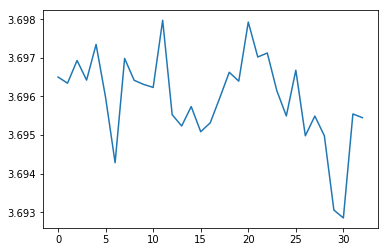

In [74]:
plt.plot(all_errors)

In [73]:
train.drop(labels=to_drop.index.values,axis=1,inplace=True)
test.drop(labels=to_drop.index.values,axis=1,inplace=True)

In [ ]:
#['purchase_size_bins']

In [4]:
#features = [c for c in best_feat if c not in ['card_id', 'first_active_month']]

features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [x for x in features if (re.match('feature_[1-2]',x) or re.match('last_purchase_month_bins',x) or re.search('_modeplus',x) or re.match('purchase_size_bins',x))]

In [ ]:
outputs = []
ptest = 1
warnings.filterwarnings("ignore")

for ptest in range(1):
    param = {
             'num_leaves': 1100, 
#             'num_threads': 4,
             'max_bin': 63, 
             'min_data_in_leaf': 10,  
             'objective':'regression',
             'max_depth': -1, 
             'tree_learner':'voting',
             'learning_rate': 0.007,
             "boosting": "gbdt", #dart, gbdt
            "feature_fraction": 0.7, # 
            "bagging_freq":5, #
            "bagging_fraction": 0.7, #
            "bagging_seed": 11,
             "metric": 'rmse',
#             "lambda_l1": 0.7 , #chd
#            'lambda_l2': 0.2, #
             "random_state": 77,
#            'reg_sqrt': True,
            'device':'gpu',
             'gpu_device_id':0,
             'gpu_platform_id':1,
            'gpu_use_dp':False,
            }

    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )

        num_round = 10000
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

#        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    errr = mean_squared_error(oof, target)**0.5
    print("CV score: {:<8.5f}".format(errr))
    outputs.append(f'{ptest}, {errr}')
    print(f'\n^ {ptest} - num leaves^ \n')

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.27024	valid_1's rmse: 3.76554
[200]	training's rmse: 2.86013	valid_1's rmse: 3.734
[300]	training's rmse: 2.53625	valid_1's rmse: 3.7241
[400]	training's rmse: 2.2694	valid_1's rmse: 3.72211


In [77]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

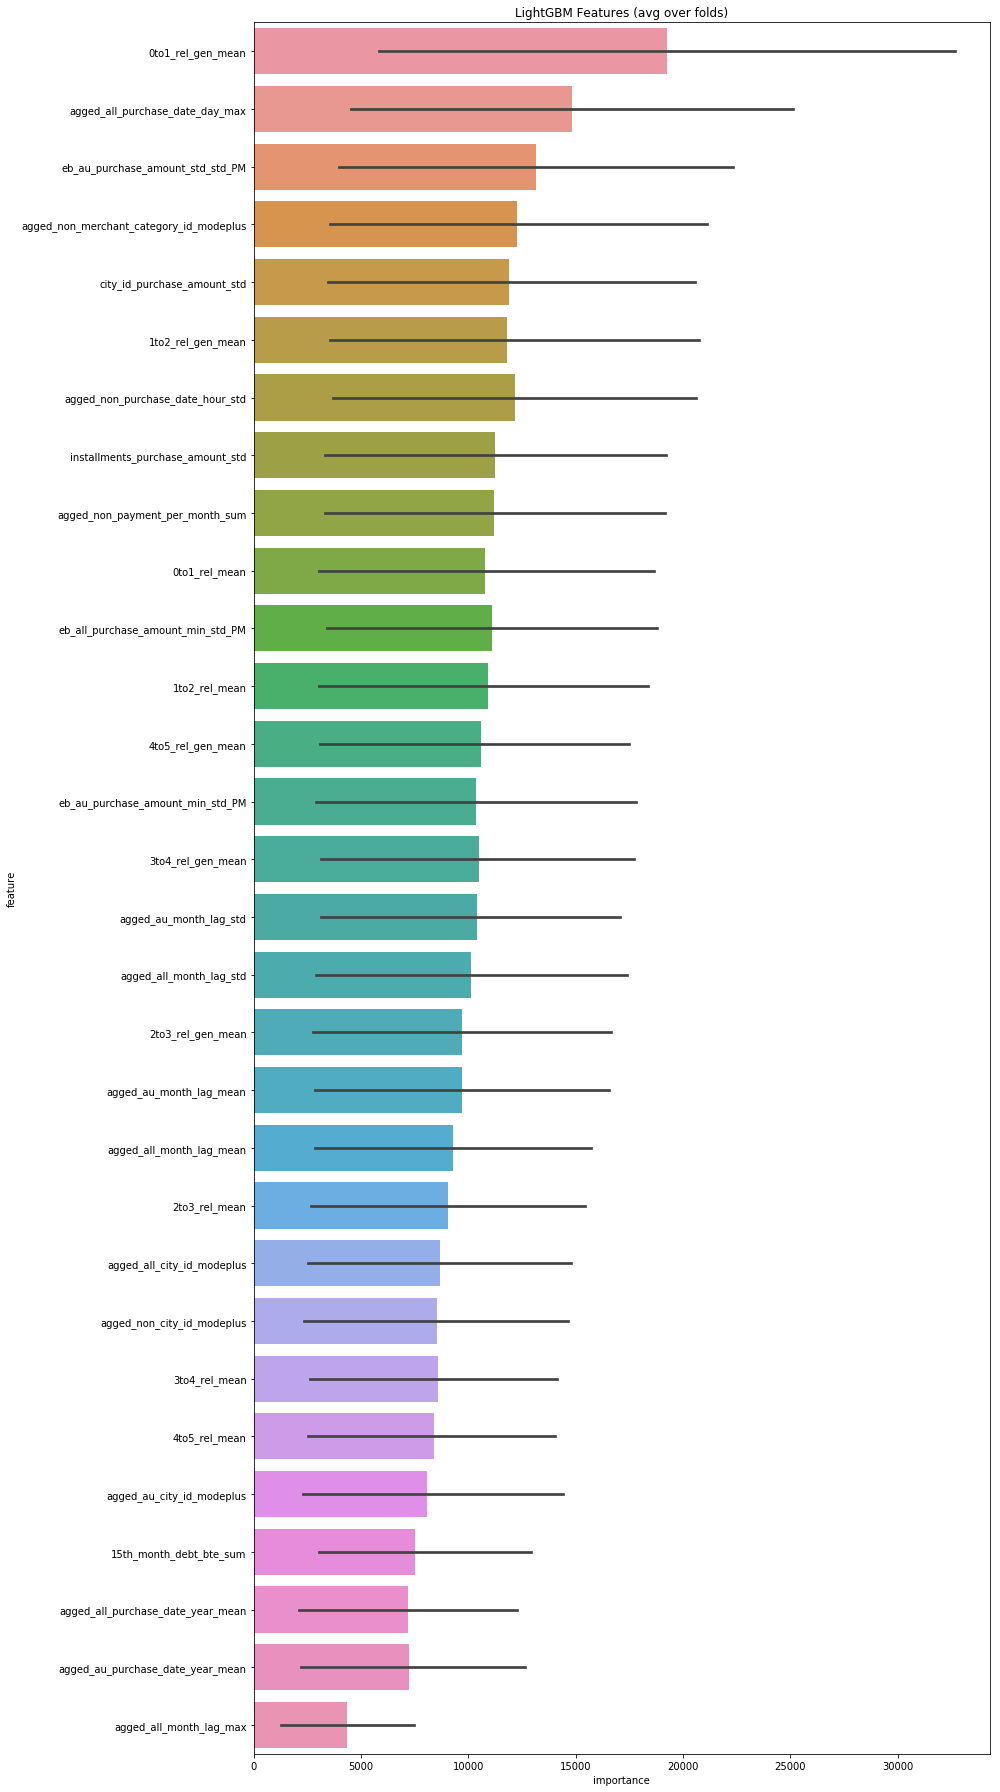

In [78]:
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [58]:
useless = pd.DataFrame(best_features.groupby(['feature'])['importance'].mean())

In [69]:
to_drop = useless[useless.importance < 2000]

In [70]:
#useless[useless.importance >= 1].sort_values('importance')

In [72]:
useless.sort_values('importance',ascending=False)

,importance
feature,
0to1_rel_gen_mean,10696.8
1to2_rel_gen_mean,6167.4
0to1_rel_mean,5242.0
1to2_rel_mean,4892.6
agged_all_purchase_date_day_max,4879.6
agged_non_merchant_category_id_modeplus,3590.4
agged_all_month_lag_max,2830.4
3to4_rel_gen_mean,2788.0
4to5_rel_gen_mean,2786.2


In [ ]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

In [5]:
feather.write_dataframe(train,'train')
feather.write_dataframe(test,'test')


#target.to_csv('target2')

In [ ]:
###################

In [2]:
train = feather.read_dataframe('train')
test = feather.read_dataframe('test')
target = pd.read_csv('target2',header=None,index_col=0)

In [ ]:
###################

In [3]:
train = feather.read_dataframe('cat_and_etb\\train_cats_and_etb')
test = feather.read_dataframe('cat_and_etb\\test_cats_and_etb')
target = train.pop('target')

In [ ]:
####################

In [56]:
train.rename(columns={x[0]:f'more_{x[1]}prc_in_merch_cat' for x in zip(train.columns.values[-5:],range(10,100,20))},inplace=True)

In [57]:
test.rename(columns={x[0]:f'more_{x[1]}prc_in_merch_cat' for x in zip(test.columns.values[-5:],range(10,100,20))},inplace=True)

In [41]:
best_feat = list(pd.read_csv('best_features_to_use').first_active_month)

In [81]:
train['target'] = target

In [93]:
max_tar = train[train.target > 3].describe()
max_tar.rename({x:('max_'+x) for x in max_tar.index.values},axis='index',inplace=True)
mid_tar = train[((train.target > -20) & (train.target < 3))].describe()
mid_tar.rename({x:('mid_'+x) for x in mid_tar.index.values},axis='index',inplace=True)
min_tar = train[train.target < -20].describe()
min_tar.rename({x:('min_'+x) for x in min_tar.index.values},axis='index',inplace=True)
comparisons = pd.concat([max_tar,mid_tar,min_tar])
indexs = []
[indexs.extend(x) for x in zip(min_tar.index.values,mid_tar.index.values,max_tar.index.values)]
comparisons = comparisons.reindex(index=indexs)
comparisons

,feature_1,feature_2,feature_3,elapsed_time,agged_all_transactions_count,agged_all_category_1_sum,agged_all_category_1_mean,agged_all_purchase_date_year_quarter_mean,agged_all_purchase_date_year_quarter_median,agged_all_city_id_modeplus,agged_all_city_id_nunique,agged_all_installments_sum,agged_all_installments_mean,agged_all_installments_max,agged_all_installments_min,agged_all_installments_std,agged_all_installments_nunique,agged_all_merchant_category_id_modeplus,agged_all_merchant_category_id_nunique,agged_all_month_lag_mean,agged_all_month_lag_max,agged_all_month_lag_min,agged_all_month_lag_std,agged_all_purchase_amount_sum,agged_all_purchase_amount_mean,agged_all_purchase_amount_max,agged_all_purchase_amount_min,agged_all_purchase_amount_std,agged_all_state_id_modeplus,agged_all_state_id_nunique,agged_all_subsector_id_modeplus,agged_all_subsector_id_nunique,agged_all_no_city_mean,agged_all_no_city_sum,agged_all_undefined_installments_mean,agged_all_undefined_installments_sum,agged_all_undefined_installments_min,agged_all_undefined_installments_max,agged_all_big_installments_mean,agged_all_big_installments_sum,agged_all_big_installments_min,agged_all_big_installments_max,agged_all_cat2_dum_0.0_mean,agged_all_cat2_dum_1.0_mean,agged_all_cat2_dum_2.0_mean,agged_all_cat2_dum_3.0_mean,agged_all_cat2_dum_4.0_mean,agged_all_cat2_dum_5.0_mean,agged_all_cat2_dum_nan_mean,agged_all_cat3_dum_A_mean,agged_all_cat3_dum_B_mean,agged_all_cat3_dum_C_mean,agged_all_cat3_dum_nan_mean,agged_all_purchase_date_all_weeks_ptp,agged_all_purchase_date_all_weeks_min,agged_all_purchase_date_all_weeks_mean,agged_all_purchase_date_all_weeks_max,agged_all_purchase_date_all_weeks_std,agged_all_purchase_amount_unusual_mean,agged_all_purchase_amount_unusual_sum,agged_all_purchase_date_year_mean,agged_all_purchase_date_year_max,agged_all_purchase_date_year_min,agged_all_purchase_date_season_mean,agged_all_purchase_date_season_modeplus,agged_all_purchase_date_season_std,agged_all_purchase_date_activity_month_mean,agged_all_purchase_date_activity_month_max,agged_all_purchase_date_activity_month_min,agged_all_purchase_date_activity_month_std,agged_all_purchase_date_activity_month_ptp,agged_all_purchase_date_month_mean,agged_all_purchase_date_month_max,agged_all_purchase_date_month_min,agged_all_purchase_date_month_std,agged_all_purchase_date_week_mean,agged_all_purchase_date_week_max,agged_all_purchase_date_week_min,agged_all_purchase_date_week_std,agged_all_purchase_date_months_week_mean,agged_all_purchase_date_months_week_std,agged_all_purchase_date_months_week_max,agged_all_purchase_date_months_week_min,agged_all_purchase_date_end_of_the_month_mean,agged_all_purchase_years_day_mean,agged_all_purchase_years_day_max,agged_all_purchase_years_day_min,agged_all_purchase_years_day_std,agged_all_purchase_years_day_ptp,agged_all_purchase_date_day_mean,agged_all_purchase_date_day_std,agged_all_purchase_date_day_max,agged_all_purchase_date_day_min,agged_all_purchase_date_weekend_mean,agged_all_purchase_date_hour_mean,agged_all_purchase_date_hour_std,agged_all_purchase_date_hour_max,agged_all_purchase_date_hour_min,agged_all_purchase_date_day_cycle_mean,agged_all_payment_per_month_sum,agged_all_payment_per_month_mean,agged_all_payment_per_month_std,agged_all_number_of_purchases_max,agged_all_valid_authorization_percent_max,agged_all_payment_from_end_to_begging_mean,agged_all_payment_from_end_to_begging_max,agged_all_payment_from_end_to_begging_min,agged_all_purchase_date_start_of_the_month_mean,agged_all_position_from_start_to_finnish_mean,agged_all_position_from_start_to_finnish_ptp,agged_all_position_from_start_to_finnish_max,agged_all_position_from_start_to_finnish_min,agged_all_debt_until_month_mean,agged_all_debt_until_month_std,agged_all_debt_until_month_ptp,eb_all_payment_from_end_to_begging_mean_PM,eb_all_payment_from_end_to_begging_std_PM,eb_all_purchase_amount_count_mean_PM,eb_all_purchase_amount_count_std_PM,eb_all_purchase_amount_sum_mean_PM,eb_all_purch

In [94]:
comparisons = comparisons.T
deviations = pd.DataFrame()
deviations['rmse_mid_to_max'] = np.sqrt((comparisons.mid_mean - comparisons.max_mean)**2)
deviations['rmse_mid_to_min'] = np.sqrt((comparisons.mid_mean - comparisons.min_mean)**2)
deviations.sort_values(['rmse_mid_to_max','rmse_mid_to_min'],ascending=False)

In [104]:
stats.describe(np.log1p(train.agged_all_purchase_amount_sum))

DescribeResult(nobs=201917, minmax=(3.8367798889341085, 17.911628289033796), mean=7.312863205650888, variance=0.9320329239851014, skewness=0.21679122790981264, kurtosis=0.5581768491838757)

In [105]:
#minmax=(3.8367798889341085, 17.911628289033796) 
mn=7.312863205650888
vrce=0.9320329239851014

In [113]:
train['purchase_size_bins'] = pd.cut(np.log1p(train.agged_all_purchase_amount_sum),bins=[3.8367798889341085,mn-vrce*3,mn-vrce*2,mn-vrce*1,mn,mn+vrce*1,mn+vrce*2,mn+vrce*3,mn+vrce*4,20],labels=range(1,10),include_lowest=True).astype(np.int8)

In [114]:
test['purchase_size_bins'] = pd.cut(np.log1p(test.agged_all_purchase_amount_sum),bins=[3.8367798889341085,mn-vrce*3,mn-vrce*2,mn-vrce*1,mn,mn+vrce*1,mn+vrce*2,mn+vrce*3,mn+vrce*4,20],labels=range(1,10),include_lowest=True).astype(np.int8)

In [128]:
train['outliner'] = (target < -20)

In [ ]:
for f in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([f])['outliner'].mean()
    
    train[f] = train[f].map(order_label)
    train[f] = train[f].map(order_label)
    
    test[f] = test[f].map(order_label)

In [129]:
order_label = train.groupby(['purchase_size_bins'])['outliner'].mean()

In [127]:
train['bot_outliner'] = train['purchase_size_bins'].map(order_label)
test['bot_outliner'] = test['purchase_size_bins'].map(order_label)

In [131]:
train['outliner'] = (target > 3)

In [132]:
order_label = train.groupby(['purchase_size_bins'])['outliner'].mean()

In [134]:
train['top_outliner'] = train['purchase_size_bins'].map(order_label)
test['top_outliner'] = test['purchase_size_bins'].map(order_label)

In [137]:
train.drop('outliner',inplace=True,axis=1)

In [138]:
train.shape,test.shape

((201917, 663), (123623, 662))

In [142]:
train.drop('target',inplace=True,axis=1)

In [141]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,agged_all_transactions_count,agged_all_category_1_sum,agged_all_category_1_mean,agged_all_purchase_date_year_quarter_mean,agged_all_purchase_date_year_quarter_median,agged_all_city_id_modeplus,agged_all_city_id_nunique,agged_all_installments_sum,agged_all_installments_mean,agged_all_installments_max,agged_all_installments_min,agged_all_installments_std,agged_all_installments_nunique,agged_all_merchant_category_id_modeplus,agged_all_merchant_category_id_nunique,agged_all_month_lag_mean,agged_all_month_lag_max,agged_all_month_lag_min,agged_all_month_lag_std,agged_all_purchase_amount_sum,agged_all_purchase_amount_mean,agged_all_purchase_amount_max,agged_all_purchase_amount_min,agged_all_purchase_amount_std,agged_all_state_id_modeplus,agged_all_state_id_nunique,agged_all_subsector_id_modeplus,agged_all_subsector_id_nunique,agged_all_no_city_mean,agged_all_no_city_sum,agged_all_undefined_installments_mean,agged_all_undefined_installments_sum,agged_all_undefined_installments_min,agged_all_undefined_installments_max,agged_all_big_installments_mean,agged_all_big_installments_sum,agged_all_big_installments_min,agged_all_big_installments_max,agged_all_cat2_dum_0.0_mean,agged_all_cat2_dum_1.0_mean,agged_all_cat2_dum_2.0_mean,agged_all_cat2_dum_3.0_mean,agged_all_cat2_dum_4.0_mean,agged_all_cat2_dum_5.0_mean,agged_all_cat2_dum_nan_mean,agged_all_cat3_dum_A_mean,agged_all_cat3_dum_B_mean,agged_all_cat3_dum_C_mean,agged_all_cat3_dum_nan_mean,agged_all_purchase_date_all_weeks_ptp,agged_all_purchase_date_all_weeks_min,agged_all_purchase_date_all_weeks_mean,agged_all_purchase_date_all_weeks_max,agged_all_purchase_date_all_weeks_std,agged_all_purchase_amount_unusual_mean,agged_all_purchase_amount_unusual_sum,agged_all_purchase_date_year_mean,agged_all_purchase_date_year_max,agged_all_purchase_date_year_min,agged_all_purchase_date_season_mean,agged_all_purchase_date_season_modeplus,agged_all_purchase_date_season_std,agged_all_purchase_date_activity_month_mean,agged_all_purchase_date_activity_month_max,agged_all_purchase_date_activity_month_min,agged_all_purchase_date_activity_month_std,agged_all_purchase_date_activity_month_ptp,agged_all_purchase_date_month_mean,agged_all_purchase_date_month_max,agged_all_purchase_date_month_min,agged_all_purchase_date_month_std,agged_all_purchase_date_week_mean,agged_all_purchase_date_week_max,agged_all_purchase_date_week_min,agged_all_purchase_date_week_std,agged_all_purchase_date_months_week_mean,agged_all_purchase_date_months_week_std,agged_all_purchase_date_months_week_max,agged_all_purchase_date_months_week_min,agged_all_purchase_date_end_of_the_month_mean,agged_all_purchase_years_day_mean,agged_all_purchase_years_day_max,agged_all_purchase_years_day_min,agged_all_purchase_years_day_std,agged_all_purchase_years_day_ptp,agged_all_purchase_date_day_mean,agged_all_purchase_date_day_std,agged_all_purchase_date_day_max,agged_all_purchase_date_day_min,agged_all_purchase_date_weekend_mean,agged_all_purchase_date_hour_mean,agged_all_purchase_date_hour_std,agged_all_purchase_date_hour_max,agged_all_purchase_date_hour_min,agged_all_purchase_date_day_cycle_mean,agged_all_payment_per_month_sum,agged_all_payment_per_month_mean,agged_all_payment_per_month_std,agged_all_number_of_purchases_max,agged_all_valid_authorization_percent_max,agged_all_payment_from_end_to_begging_mean,agged_all_payment_from_end_to_begging_max,agged_all_payment_from_end_to_begging_min,agged_all_purchase_date_start_of_the_month_mean,agged_all_position_from_start_to_finnish_mean,agged_all_position_from_start_to_finnish_ptp,agged_all_position_from_start_to_finnish_max,agged_all_position_from_start_to_finnish_min,agged_all_debt_until_month_mean,agged_all_debt_until_month_std,agged_all_debt_until_month_ptp,eb_all_payment_from_end_to_begging_mean_PM,eb_all_payment_from_end_to_begging_std_PM,eb_all_purchase_amount_count_mean_PM,eb_all_purchase_amount_count_std_PM,eb_all_purchase_amou

In [11]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,agged_all_transactions_count,agged_all_category_1_sum,agged_all_category_1_mean,agged_all_purchase_date_year_quarter_mean,agged_all_purchase_date_year_quarter_median,agged_all_city_id_modeplus,agged_all_city_id_nunique,agged_all_installments_sum,agged_all_installments_mean,agged_all_installments_max,agged_all_installments_min,agged_all_installments_std,agged_all_installments_nunique,agged_all_merchant_category_id_modeplus,agged_all_merchant_category_id_nunique,agged_all_month_lag_mean,agged_all_month_lag_max,agged_all_month_lag_min,agged_all_month_lag_std,agged_all_purchase_amount_sum,agged_all_purchase_amount_mean,agged_all_purchase_amount_max,agged_all_purchase_amount_min,agged_all_purchase_amount_std,agged_all_state_id_modeplus,agged_all_state_id_nunique,agged_all_subsector_id_modeplus,agged_all_subsector_id_nunique,agged_all_no_city_mean,agged_all_no_city_sum,agged_all_undefined_installments_mean,agged_all_undefined_installments_sum,agged_all_undefined_installments_min,agged_all_undefined_installments_max,agged_all_big_installments_mean,agged_all_big_installments_sum,agged_all_big_installments_min,agged_all_big_installments_max,agged_all_cat2_dum_0.0_mean,agged_all_cat2_dum_1.0_mean,agged_all_cat2_dum_2.0_mean,agged_all_cat2_dum_3.0_mean,agged_all_cat2_dum_4.0_mean,agged_all_cat2_dum_5.0_mean,agged_all_cat2_dum_nan_mean,agged_all_cat3_dum_A_mean,agged_all_cat3_dum_B_mean,agged_all_cat3_dum_C_mean,agged_all_cat3_dum_nan_mean,agged_all_purchase_date_all_weeks_ptp,agged_all_purchase_date_all_weeks_min,agged_all_purchase_date_all_weeks_mean,agged_all_purchase_date_all_weeks_max,agged_all_purchase_date_all_weeks_std,agged_all_purchase_amount_unusual_mean,agged_all_purchase_amount_unusual_sum,agged_all_purchase_date_year_mean,agged_all_purchase_date_year_max,agged_all_purchase_date_year_min,agged_all_purchase_date_season_mean,agged_all_purchase_date_season_modeplus,agged_all_purchase_date_season_std,agged_all_purchase_date_activity_month_mean,agged_all_purchase_date_activity_month_max,agged_all_purchase_date_activity_month_min,agged_all_purchase_date_activity_month_std,agged_all_purchase_date_activity_month_ptp,agged_all_purchase_date_month_mean,agged_all_purchase_date_month_max,agged_all_purchase_date_month_min,agged_all_purchase_date_month_std,agged_all_purchase_date_week_mean,agged_all_purchase_date_week_max,agged_all_purchase_date_week_min,agged_all_purchase_date_week_std,agged_all_purchase_date_months_week_mean,agged_all_purchase_date_months_week_std,agged_all_purchase_date_months_week_max,agged_all_purchase_date_months_week_min,agged_all_purchase_date_end_of_the_month_mean,agged_all_purchase_years_day_mean,agged_all_purchase_years_day_max,agged_all_purchase_years_day_min,agged_all_purchase_years_day_std,agged_all_purchase_years_day_ptp,agged_all_purchase_date_day_mean,agged_all_purchase_date_day_std,agged_all_purchase_date_day_max,agged_all_purchase_date_day_min,agged_all_purchase_date_weekend_mean,agged_all_purchase_date_hour_mean,agged_all_purchase_date_hour_std,agged_all_purchase_date_hour_max,agged_all_purchase_date_hour_min,agged_all_purchase_date_day_cycle_mean,agged_all_payment_per_month_sum,agged_all_payment_per_month_mean,agged_all_payment_per_month_std,agged_all_number_of_purchases_max,agged_all_valid_authorization_percent_max,agged_all_payment_from_end_to_begging_mean,agged_all_payment_from_end_to_begging_max,agged_all_payment_from_end_to_begging_min,agged_all_purchase_date_start_of_the_month_mean,agged_all_position_from_start_to_finnish_mean,agged_all_position_from_start_to_finnish_ptp,agged_all_position_from_start_to_finnish_max,agged_all_position_from_start_to_finnish_min,agged_all_debt_until_month_mean,agged_all_debt_until_month_std,agged_all_debt_until_month_ptp,eb_all_payment_from_end_to_begging_mean_PM,eb_all_payment_from_end_to_begging_std_PM,eb_all_purchase_amount_count_mean_PM,eb_all_purchase_amount_count_std_PM,eb_all_purchase_amou

In [16]:
for df in [train,test]:
    df['avg_num_of_purchase_per_day'] = df.agged_all_transactions_count/(df.agged_all_purchase_date_day_max - df.agged_all_purchase_date_day_min)

In [17]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,agged_all_transactions_count,agged_all_category_1_sum,agged_all_category_1_mean,agged_all_purchase_date_year_quarter_mean,agged_all_purchase_date_year_quarter_median,agged_all_city_id_modeplus,agged_all_city_id_nunique,agged_all_installments_sum,agged_all_installments_mean,agged_all_installments_max,agged_all_installments_min,agged_all_installments_std,agged_all_installments_nunique,agged_all_merchant_category_id_modeplus,agged_all_merchant_category_id_nunique,agged_all_month_lag_mean,agged_all_month_lag_max,agged_all_month_lag_min,agged_all_month_lag_std,agged_all_purchase_amount_sum,agged_all_purchase_amount_mean,agged_all_purchase_amount_max,agged_all_purchase_amount_min,agged_all_purchase_amount_std,agged_all_state_id_modeplus,agged_all_state_id_nunique,agged_all_subsector_id_modeplus,agged_all_subsector_id_nunique,agged_all_no_city_mean,agged_all_no_city_sum,agged_all_undefined_installments_mean,agged_all_undefined_installments_sum,agged_all_undefined_installments_min,agged_all_undefined_installments_max,agged_all_big_installments_mean,agged_all_big_installments_sum,agged_all_big_installments_min,agged_all_big_installments_max,agged_all_cat2_dum_0.0_mean,agged_all_cat2_dum_1.0_mean,agged_all_cat2_dum_2.0_mean,agged_all_cat2_dum_3.0_mean,agged_all_cat2_dum_4.0_mean,agged_all_cat2_dum_5.0_mean,agged_all_cat2_dum_nan_mean,agged_all_cat3_dum_A_mean,agged_all_cat3_dum_B_mean,agged_all_cat3_dum_C_mean,agged_all_cat3_dum_nan_mean,agged_all_purchase_date_all_weeks_ptp,agged_all_purchase_date_all_weeks_min,agged_all_purchase_date_all_weeks_mean,agged_all_purchase_date_all_weeks_max,agged_all_purchase_date_all_weeks_std,agged_all_purchase_amount_unusual_mean,agged_all_purchase_amount_unusual_sum,agged_all_purchase_date_year_mean,agged_all_purchase_date_year_max,agged_all_purchase_date_year_min,agged_all_purchase_date_season_mean,agged_all_purchase_date_season_modeplus,agged_all_purchase_date_season_std,agged_all_purchase_date_activity_month_mean,agged_all_purchase_date_activity_month_max,agged_all_purchase_date_activity_month_min,agged_all_purchase_date_activity_month_std,agged_all_purchase_date_activity_month_ptp,agged_all_purchase_date_month_mean,agged_all_purchase_date_month_max,agged_all_purchase_date_month_min,agged_all_purchase_date_month_std,agged_all_purchase_date_week_mean,agged_all_purchase_date_week_max,agged_all_purchase_date_week_min,agged_all_purchase_date_week_std,agged_all_purchase_date_months_week_mean,agged_all_purchase_date_months_week_std,agged_all_purchase_date_months_week_max,agged_all_purchase_date_months_week_min,agged_all_purchase_date_end_of_the_month_mean,agged_all_purchase_years_day_mean,agged_all_purchase_years_day_max,agged_all_purchase_years_day_min,agged_all_purchase_years_day_std,agged_all_purchase_years_day_ptp,agged_all_purchase_date_day_mean,agged_all_purchase_date_day_std,agged_all_purchase_date_day_max,agged_all_purchase_date_day_min,agged_all_purchase_date_weekend_mean,agged_all_purchase_date_hour_mean,agged_all_purchase_date_hour_std,agged_all_purchase_date_hour_max,agged_all_purchase_date_hour_min,agged_all_purchase_date_day_cycle_mean,agged_all_payment_per_month_sum,agged_all_payment_per_month_mean,agged_all_payment_per_month_std,agged_all_number_of_purchases_max,agged_all_valid_authorization_percent_max,agged_all_payment_from_end_to_begging_mean,agged_all_payment_from_end_to_begging_max,agged_all_payment_from_end_to_begging_min,agged_all_purchase_date_start_of_the_month_mean,agged_all_position_from_start_to_finnish_mean,agged_all_position_from_start_to_finnish_ptp,agged_all_position_from_start_to_finnish_max,agged_all_position_from_start_to_finnish_min,agged_all_debt_until_month_mean,agged_all_debt_until_month_std,agged_all_debt_until_month_ptp,eb_all_payment_from_end_to_begging_mean_PM,eb_all_payment_from_end_to_begging_std_PM,eb_all_purchase_amount_count_mean_PM,eb_all_purchase_amount_count_std_PM,eb_all_purchase_amou